In [13]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%reload_ext autoreload

In [16]:
from TargetDistributions.Mueller_potential import MuellerPotential
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [17]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [18]:
dim = 2
target = MuellerPotential()

In [19]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [20]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.0003295524971409476,           var is 3.0337212833121655e-05


# DReG likelihood

In [25]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type=False, n_distributions=10, n_steps_transition_operator=3,
                    step_size=1.0, transition_operator="HMC", learnt_dist_kwargs={"lr": 1e-4},
                     loss_type_2="alpha_2")

In [26]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.0001


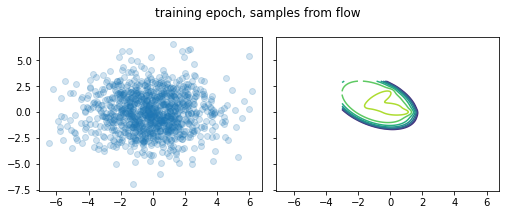

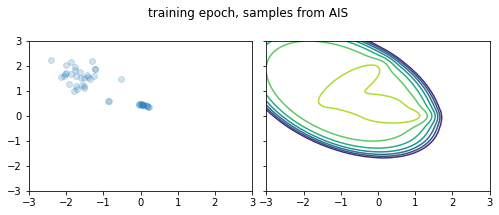

In [27]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

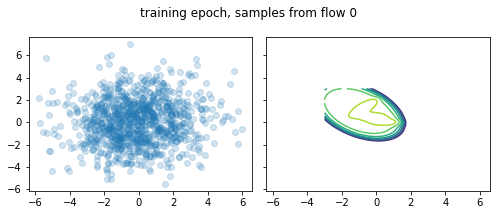

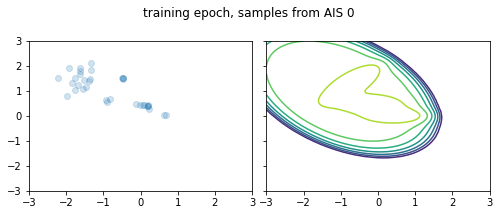

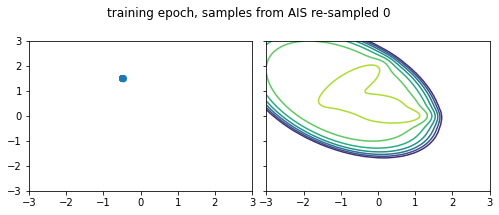

loss: 290.50068483200437,   log_p_x_post_AIS -184.463298718069, ESS 0.001995675101364618:  10%|█████▌                                                 | 50/500 [06:41<53:59,  7.20s/it]

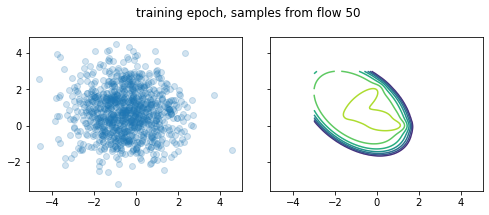

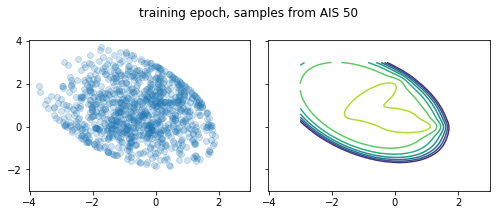

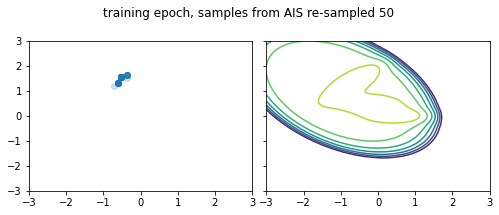

loss: 293.94976876005614,   log_p_x_post_AIS -40.63313874001639, ESS 0.003436052708729772:  20%|██████████▌                                          | 100/500 [12:58<55:18,  8.30s/it]

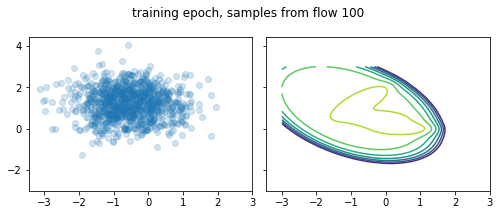

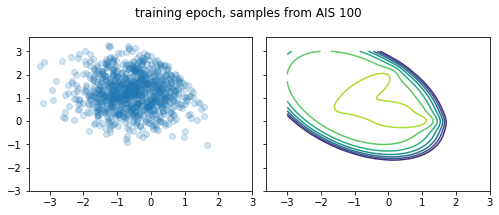

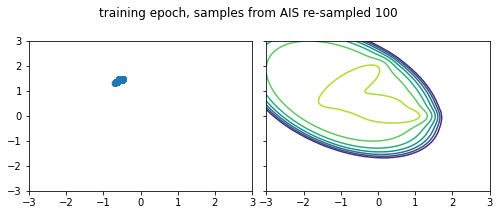

loss: 294.5881644928674,   log_p_x_post_AIS 129.2860386214983, ESS 0.06823411290405036:  30%|████████████████▊                                       | 150/500 [20:09<44:57,  7.71s/it]

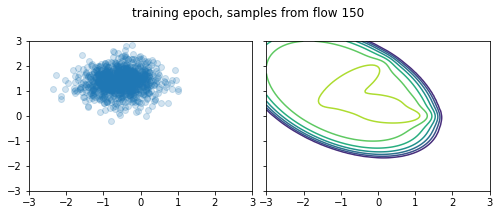

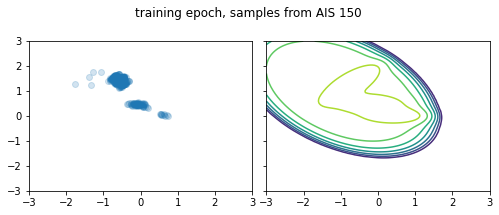

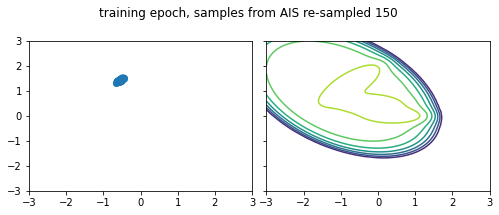

loss: 293.7436671028705,   log_p_x_post_AIS 139.60324625210876, ESS 0.04812096668590208:  40%|██████████████████████                                 | 200/500 [27:04<39:17,  7.86s/it]

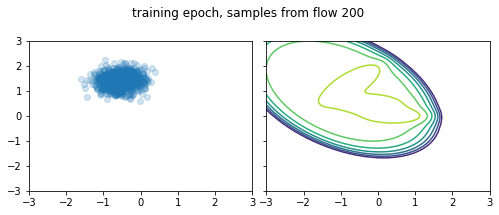

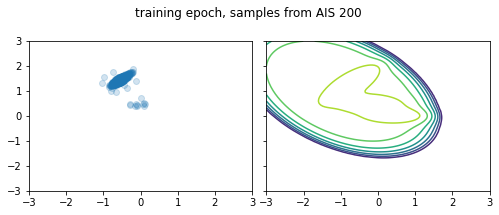

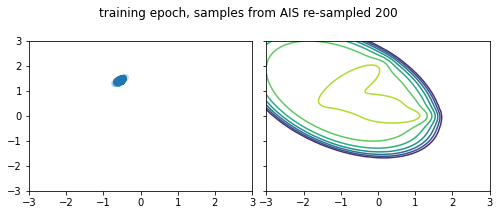

loss: 292.7907054757235,   log_p_x_post_AIS 141.83927569431034, ESS 0.08796220785824016:  50%|███████████████████████████▌                           | 250/500 [34:01<37:02,  8.89s/it]

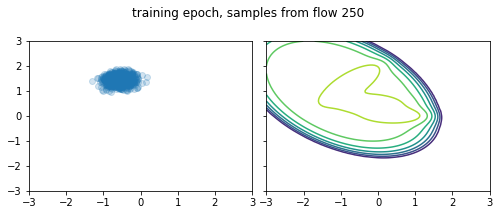

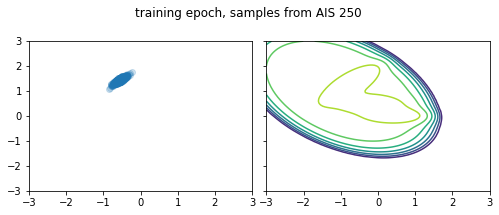

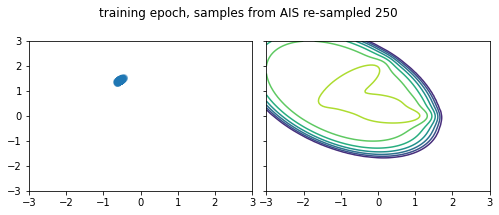

loss: 291.7495023606319,   log_p_x_post_AIS 143.801960272995, ESS 0.21691248405392521:  60%|██████████████████████████████████▏                      | 300/500 [40:31<25:35,  7.68s/it]

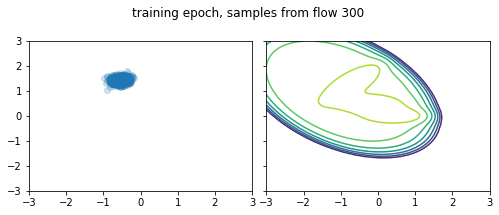

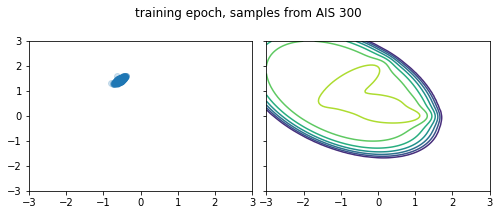

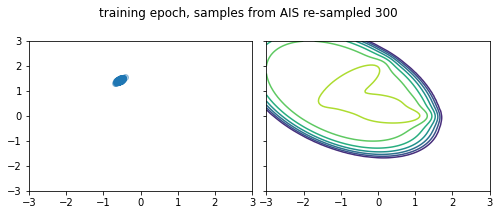

loss: 290.97225015267503,   log_p_x_post_AIS 144.47836036956454, ESS 0.42357329469838856:  70%|█████████████████████████████████████▊                | 350/500 [47:21<20:07,  8.05s/it]

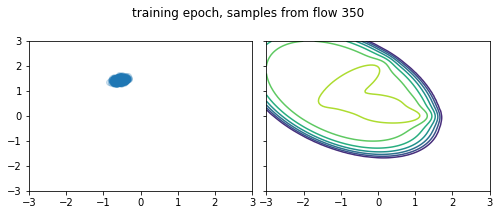

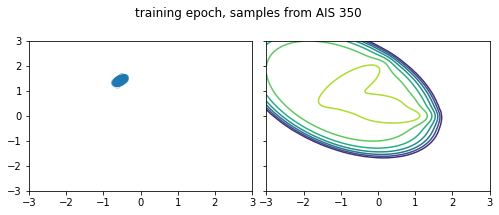

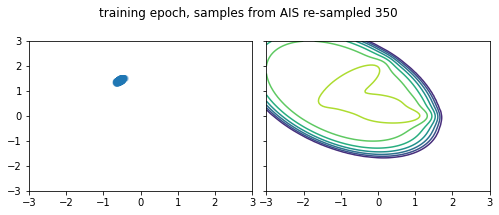

loss: 290.2674583894267,   log_p_x_post_AIS 144.88905103137637, ESS 0.6910089233377523:  80%|████████████████████████████████████████████▊           | 400/500 [54:10<13:16,  7.97s/it]

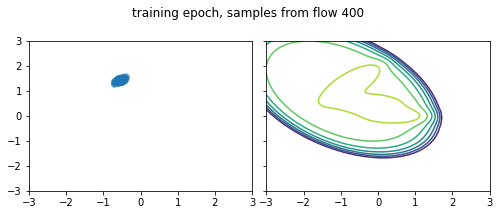

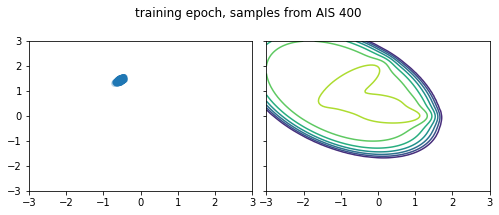

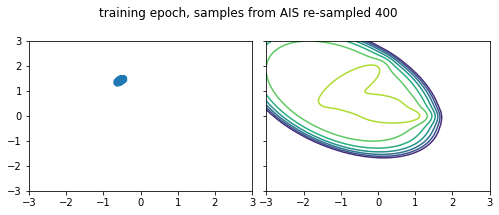

loss: 289.8744788637962,   log_p_x_post_AIS 145.3397084703634, ESS 0.8910582801664549:  90%|█████████████████████████████████████████████████▌     | 450/500 [1:01:03<06:50,  8.22s/it]

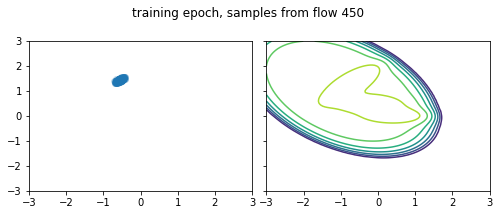

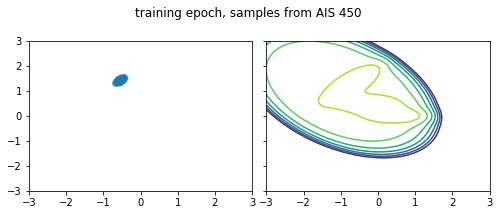

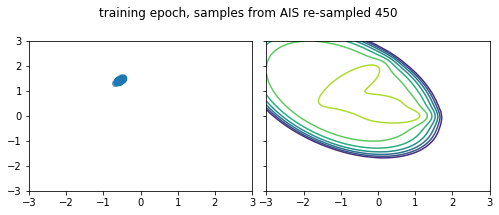

loss: 289.7472804613968,   log_p_x_post_AIS 145.46772570770446, ESS 0.9509653076924318: 100%|██████████████████████████████████████████████████████| 500/500 [1:07:54<00:00,  8.15s/it]


In [28]:
history = tester.train(500, batch_size=int(1e3), intermediate_plots=True, n_plots=10, plotting_func=plotter)

NaN encountered in log_w history


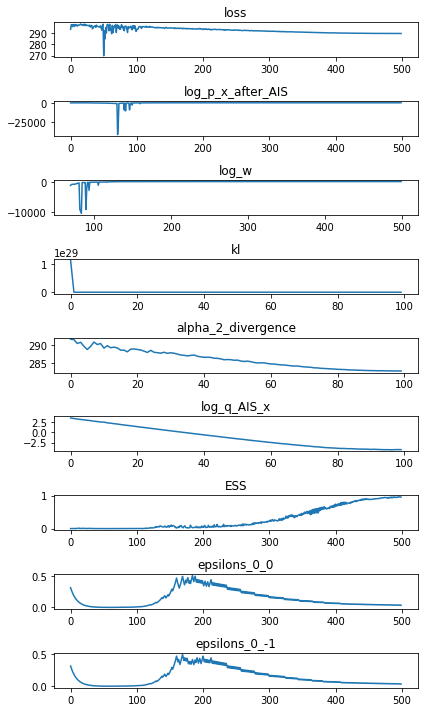

In [29]:
plot_history(history)

NaN encountered in log_w history


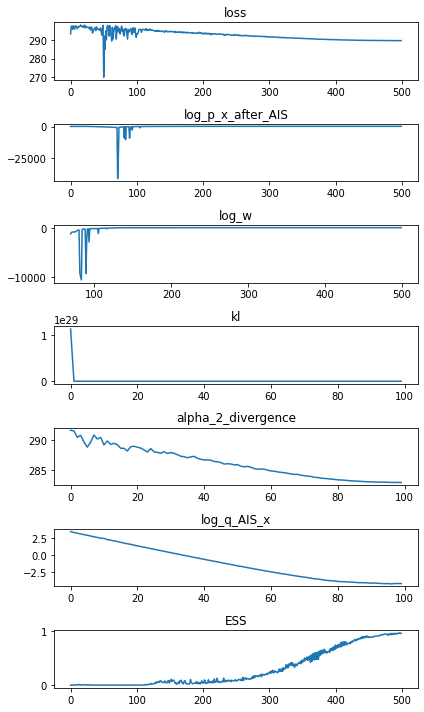

In [30]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [31]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

AttributeError: 'HMC' object has no attribute 'train_params'

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])